In [13]:
import repackage
repackage.up()
import numpy as np
from numpy import random as rand
import matplotlib.pyplot as plt
from tqdm import trange
from OptSegSI import optSegSI

import ruptures as rpt
from scipy.stats import ttest_ind

In [14]:
K = 1
eps = 1
cps = [8, 20]
num = 100
N_values = [10, 50, 100]
p_values = np.empty((len(N_values),K, num))

for i,N in enumerate(N_values):
    Sigma = eps**2 * np.identity(N)
    mu = np.zeros(N)
    white_noise = mu[None,:] + eps * rand.randn(num, len(mu))
    #white_noise  = eps * rand.randn(num, len(mu))
    for j in trange(num):
        p_values[i, :, j] = np.exp(optSegSI(white_noise[j], N, K, Sigma, pruning=False))

100%|██████████| 100/100 [04:14<00:00,  2.54s/it]


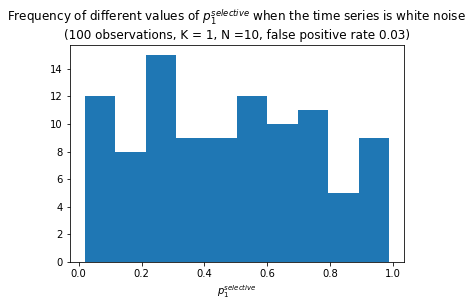

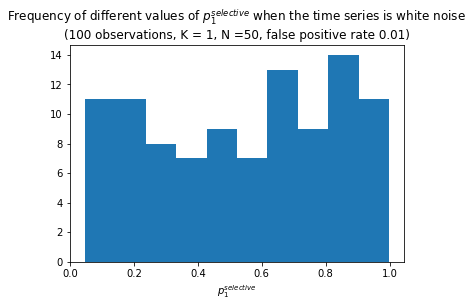

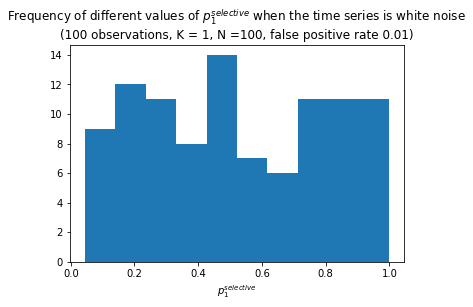

<Figure size 432x288 with 0 Axes>

In [15]:
alpha = 0.05
for i, N in enumerate(N_values):
    plt.hist(p_values[i,0])
    plt.xlabel(r"$p_1^{selective}$")
    title = r"Frequency of different values of $p_1^{selective}$ when the time series is white noise "
    plt.title(title + f"\n({num} observations, K = {K}, N ={N}, false positive rate {(p_values[i,0]<alpha).sum()/num})")
    plt.savefig(f"../plots/p_distribution_N_{N}.png", bbox_inches = "tight")
    plt.show()
    plt.clf()

# Comparison with T-test

In [25]:
def fig_ax(nrows=1, figsize=(15, 3)):
    return plt.subplots(nrows=nrows, figsize=(figsize[0], figsize[1] * nrows))

First we generate white noise

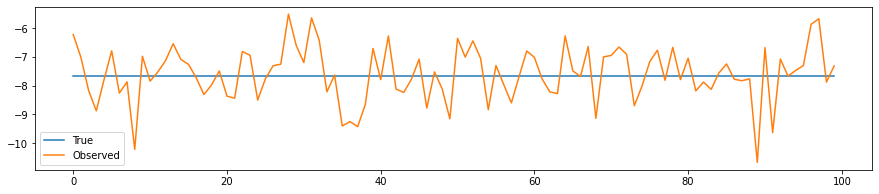

In [26]:
n_samples = 100
n_bkps = 0
n_dims = 1
sigma_noise = 1
signal, bkps = rpt.pw_constant(
    n_samples=n_samples, n_features=n_dims, n_bkps=n_bkps, noise_std=0
)
signal_with_noise = signal + np.random.normal(
    scale=sigma_noise, size=signal.shape
)

fig, ax = fig_ax()
ax.plot(signal, label="True")
ax.plot(signal_with_noise, label="Observed")
_ = plt.legend()
    

We estimate the variance

In [27]:
estimated_sigma = np.std(signal_with_noise[:50])
estimated_Sigma = estimated_sigma**2* np.identity(n_samples)

We look for a breakpoint and calculate the associated p-value. Repeated experiments show that the t-test suffers from *selection bias*.

In [28]:
log_p_values, detected_change_points = optSegSI(signal_with_noise.flatten(), n_samples, 1, estimated_Sigma, verbose=False, with_tau_det=True)
print(f"Changepoint detected at time {detected_change_points[1]}")
print(f"p_value of {np.exp(log_p_values[0])} obtained with selective inference")
ttest = ttest_ind(
    signal_with_noise[:detected_change_points[1]],
    signal_with_noise[detected_change_points[1]:],
)
print(f"p_value of {ttest.pvalue[0]} obtained with naive t-test")

Changepoint detected at time 94
p_value of 0.8620790016822544 obtained with selective inference
p_value of 0.0702945363937186 obtained with naive t-test
